In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from astropy.wcs import WCS
from scipy import ndimage
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
from time import localtime, strftime, time

In [2]:
import os.path
import glob

In [3]:
figurepath    = '/vol/aibn1081/data1/brodriguez/Figures/'
databasepath  = '/vol/aibn1081/data1/brodriguez/Databases/'
califaoutpath = '/vol/aibn1081/data1/brodriguez/CALIFA/'
acaoutpath    = '/vol/aibn1081/data1/brodriguez/ACA/'
califainpath  = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acainpath     = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

In [4]:
aca_table = pd.read_csv(databasepath+'ACA_sourcelist.csv',sep=',',index_col=0)

In [5]:
aca_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, CGCG429-012 to VV488NED02
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   califa_file         60 non-null     object 
 1   Final_QS            60 non-null     object 
 2   Final_NA            60 non-null     object 
 3   RA                  60 non-null     float64
 4   DEC                 60 non-null     float64
 5   inclination_ACA     60 non-null     int64  
 6   PA_ACA              60 non-null     int64  
 7   z_ACA               60 non-null     float64
 8   Dist_Mpc_ACA        60 non-null     int64  
 9   Re_arc_ACA          60 non-null     float64
 10  z_stars             60 non-null     float64
 11  inclination_califa  60 non-null     float64
 12  PA_califa           60 non-null     float64
 13  Re_arc_califa       60 non-null     float64
 14  Re_kpc_califa       60 non-null     float64
 15  log_Mass            60 non-null     float64
 1

In [5]:
aca_table = aca_table[aca_table['inclination_califa']<70]

In [6]:
print(len(aca_table))

41


In [7]:
sources = aca_table[aca_table['califa_file']!='---'].index.to_numpy()

In [8]:
aca_table = aca_table.loc[sources]

In [9]:
print(len(aca_table))

40


In [10]:
np.median(aca_table['z_stars'])

0.0163475239623739

In [11]:
from astropy.cosmology import LambdaCDM#, FlatLambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [12]:
def get_data(filename,header=False):
    hdu_list = fits.open(filename)
    data = hdu_list[0].data
    hdr = hdu_list[0].header
    hdu_list.close()
    if header:
        return data, hdr
    else:
        return data

In [304]:
for source in sources[:]:
    #print('\nInitializing source',source)
    #M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    if (F_Ha[Ha_mask]/eF_Ha[Ha_mask]<3).any():
    #if (F_Ha/eF_Ha<1).any():
        print('Source:',source)

## Main $\Sigma_*$ - $\Sigma_\mathrm{SFR}$ - $\Sigma_\mathrm{mol}$ database from ACA-EDGE sources

In [13]:
def deproject(ra, dec, galpos, vector = False,gal=None):

    np.seterr(divide='ignore', invalid='ignore')
    #print(ra.shape,dec.shape)

    if not gal is None:
        pa = np.deg2rad(gal["posang_deg"])
        inc = np.deg2rad(gal["incl_def"])
        xctr = gal["ra_deg"]
        yctr = gal["dec_deg"]
    elif len(galpos) == 5:
        vlsr = galpos[0]
        pa   = np.deg2rad(galpos[1])
        inc  = np.deg2rad(galpos[2])
        xctr = galpos[3]
        yctr = galpos[4]
    else:
        pa   = np.deg2rad(galpos[0])
        inc  = np.deg2rad(galpos[1])
        xctr = galpos[2]
        yctr = galpos[3]

    ra_size = np.shape(ra)
    dec_size = np.shape(dec)

    if ra_size[0]==1 and vector==False:
        # IF THE USER HAS SUPPLIED ARRAYS AND NOT IMAGES THEN MAKE 2-D GRID,
        # ONE CONTAINING RA AND ONE CONTAINING DEC
        rimg = np.outer(ra, np.ones(len(dec)))
        dimg = np.outer(np.ones(len(ra)), dec)
    else:
        rimg = ra
        dimg = dec
    # RECAST THE RA AND DEC ARRAYS IN TERMS OF THE CENTERS
    # ARRAYS ARE NOW IN DEGREES FROM CENTER
    xgrid = (rimg - xctr)*np.cos(np.deg2rad(yctr))
    ygrid = (dimg - yctr)
    # ROTATION ANGLE (ROTATE YOUR X-AXIS UP TO THE MAJOR AXIS)
    rotang =  (-1.*(pa - 1.0*np.pi/2.))
    # MAKE 2-D GRIDS FOR ROTATED X AND Y
    deproj_x = xgrid * np.cos(rotang) + ygrid * np.sin(rotang)
    deproj_y = ygrid * np.cos(rotang) - xgrid * np.sin(rotang)
    # REMOVE INCLINATION EFFECT
    deproj_y = deproj_y / np.cos((inc))
    # MAKE GRID OF DEPROJECTED DISTANCE FROM THE CENTER
    rgrid = np.sqrt(deproj_x**2 + deproj_y**2)
    #print(rgrid.shape)
    # MAKE GRID OF ANGLE W.R.T. PA
    tgrid = np.arctan2(deproj_y, deproj_x)

    return rgrid, tgrid

In [14]:
G = const.G.to(u.kpc**3/(u.Msun*u.s**2)).value # gravitational constant
k_B = (const.k_B).to(u.Msun*u.kpc**2/u.s**2/u.K).value # Boltzmann constant
S_H1 = 7.*10**6 # average atomic gas mass surface density in M_sun kpc^-2
Z_sun = 4.9*10**-4 # solar metallicity, Baumgartner & Mushotzky 2006
alphaCO_MW = 4.3 # M_sun/(K km s^-1 pc^2) from Milky Way observations

In [15]:
def create_bins(number,bin_width=1):
    q = np.floor(number/bin_width)
    return q*bin_width

In [16]:
D4000_sSFR = pd.read_csv(databasepath+'D4000_sSFR_2024-07-18.csv',index_col=0)
D4_binwidth = 0.05
#D4000_sSFR.index = create_bins(D4000_sSFR['D4000'],D4_binwidth)

In [17]:
D4000_sSFR

,D4000.1,sSFR_D4,sSFR_D4_lower,sSFR_D4_upper,sSFR_D4_uncl,sSFR_D4_uncu
D4000,,,,,,
0.95,0.978470,2.052726e-10,4.930045e-11,7.501569e-10,1.559722e-10,5.448842e-10
1.00,1.027844,1.395570e-10,4.072432e-11,5.159587e-10,9.883267e-11,3.764017e-10
1.05,1.074001,9.900109e-11,3.304975e-11,3.538883e-10,6.595134e-11,2.548872e-10
1.10,1.125969,7.536624e-11,2.698209e-11,2.625535e-10,4.838415e-11,1.871873e-10
1.15,1.177288,6.641483e-11,2.075978e-11,2.102454e-10,4.565505e-11,1.438305e-10
1.20,1.224799,5.694296e-11,1.697117e-11,1.753842e-10,3.997179e-11,1.184412e-10
1.25,1.275396,5.371554e-11,1.802671e-11,1.670772e-10,3.568883e-11,1.133617e-10
1.30,1.324133,4.526449e-11,1.322953e-11,1.376289e-10,3.203496e-11,9.236438e-11
1.35,1.375348,3.895438e-11,1.389493e-12,1.330331e-10,3.756489e-11,9.407874e-11


In [18]:
D4000_min = 0.95#np.min(D4000_sSFR.index)
D4000_max = 1.45#np.max(D4000_sSFR.index)
print(D4000_min,D4000_max)

0.95 1.45


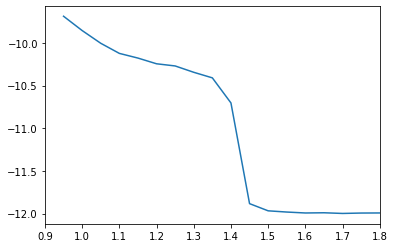

In [19]:
plt.plot(D4000_sSFR.index.to_numpy(),np.log10(D4000_sSFR['sSFR_D4'].to_numpy()))
plt.xlim(0.9,1.8)
plt.show()

In [20]:
import warnings
from spectral_cube.utils import SpectralCubeWarning
warnings.filterwarnings(action='ignore', category=SpectralCubeWarning,append=True)

In [130]:
#Database = []
#for n,source in enumerate(sources[:]):
    #print(f'\nInitializing source {n+1} of {len(sources)}:',source)
source = 'UGC12250'
z = aca_table.loc[source,'z_stars']
inc = aca_table.loc[source,'inclination_califa']
cos = np.cos(np.deg2rad(inc))
PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
D_lum = cosmo.luminosity_distance(z)
D_ang = cosmo.angular_diameter_distance(z)
Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
hs = Re/(1.68*7.3) # disc scale height in kpc
QS = aca_table.loc[source,'Final_QS']
NA = aca_table.loc[source,'Final_NA']
    
    # Deprojecting inclination effects
reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
mom0 = reduced_cube.moment(order=0)
dec, ra = mom0.world[:]
ra = ra.value
dec = dec.value
rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
#    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    #CO_int = np.where(np.log10(CO_vdisp)>-1,CO_int,np.nan)
    #CO_vdisp = np.where(np.log10(CO_vdisp)>-1,CO_vdisp,np.nan)
    
Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
eMstar, califa_hdr = get_data(califaoutpath+source+'_eMstar.fits',header=True)
region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
#    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
#F_NII = get_data(califaoutpath+source+'_F_NII.fits')
#F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
#F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
#eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
#    D4000 = get_data(califaoutpath+source+'_D4000.fits')
califa_hdr3D['NAXIS1'] = 0
califa_hdr3D['NAXIS2'] = 0

    # defining beam properties for convolution
fwhm_califa = 1.65
fwhm_aca = 6.
beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    #beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
beam_aca = reduced_cube.beam
    
#    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
#    Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
#    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
#    A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
#    A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
#    SFR = 7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    # 1.6 factor converts from Salpeter IMF to Kroupa IMF
    #SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
      
    
    # convolving CALIFA mpas to ACA resolution
#frames_cube = SpectralCube(data=np.array([Mstar,F_NII,F_OIII,F_Ha,F_Hb,SFR,SFR_D4]),wcs=WCS(califa_hdr3D))
frames_cube = SpectralCube(data=np.array([Mstar,F_Ha,
                                          eMstar**2,eF_Ha**2]),wcs=WCS(califa_hdr3D))
frames_cube = frames_cube.with_mask(region)
frames_cube = frames_cube.with_beam(beam_califa)
frames_cube_convolved = frames_cube.convolve_to(beam_aca)
frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])

#frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])
frames_cube_convolved[-2:] = np.sqrt(frames_cube_convolved[-2:])


area_factor = pix_area_aca.value/pix_area_califa.value
reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
#Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
#D4_mask_rep = reproject_exact((D4_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
[Mstar_rep,F_Ha_rep,eMstar_rep,eF_Ha_rep] = reprojected_list
    
#Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
#Ha_to_Hb_rep = np.where(F_Ha_rep>0,Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
#A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
#A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
#A_Ha_rep = np.where(np.isnan(F_Hb_rep)&(F_Ha_rep>0),A_Ha_median_rep,A_Ha_rep)
    
    #SFR_rep = 1.6*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    #SFR_rep = 7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    #R_21_rep = S_SFR_rep**0.1
    #R_21_rep = (S_SFR_rep1**0.12)*(10**-0.06)
    
S_Mstar_rep = Mstar_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
S_Mstar     = Mstar*cos/pix_area_califa.value
S_F_Ha_rep  = F_Ha_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
S_F_Ha      = F_Ha*cos/pix_area_califa.value

eS_Mstar_rep = eMstar_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
eS_Mstar     = eMstar*cos/pix_area_califa.value
eS_F_Ha_rep  = eF_Ha_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
eS_F_Ha      = eF_Ha*cos/pix_area_califa.value

#    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
#    S_SFR_rep2  = SFR_rep2 *cos/pix_area_aca.value
#    S_SFR_D4_rep = SFR_D4_rep*cos/pix_area_aca.value


In [51]:
beam_aca

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [57]:
from matplotlib.patches import Ellipse

In [60]:
beam_aca.major.value

0.002623496323459

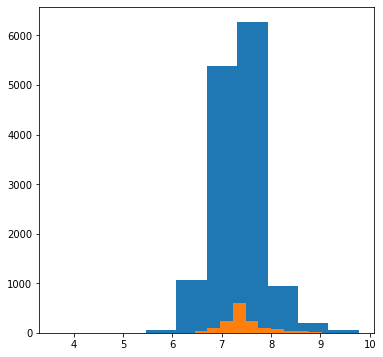

In [131]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(np.log10(S_Mstar[S_Mstar>0]))
ax.hist(np.log10(S_Mstar_rep[S_Mstar_rep>0]))
plt.show()

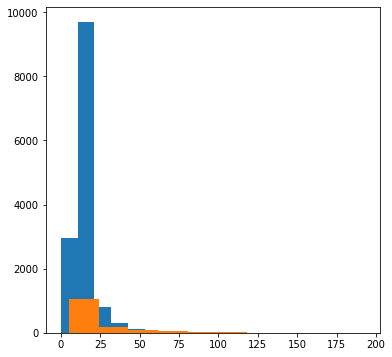

In [125]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(eS_Mstar[S_Mstar>0])
ax.hist(eS_Mstar_rep[S_Mstar_rep>0])
plt.show()

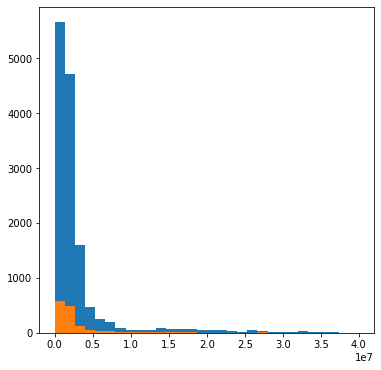

In [132]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(S_Mstar[S_Mstar>0]/eS_Mstar[S_Mstar>0],bins=np.linspace(0,0.4*10**8,31))
ax.hist(S_Mstar_rep[S_Mstar_rep>0]/eS_Mstar_rep[S_Mstar_rep>0],bins=np.linspace(0,0.4*10**8,31))
plt.show()

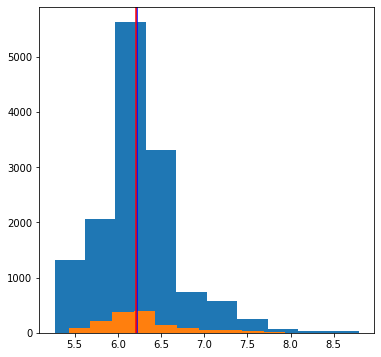

In [133]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(np.log10(S_Mstar/eS_Mstar)[S_Mstar>0])#,bins=np.linspace(5.2,9,31))
ax.hist(np.log10(S_Mstar_rep/eS_Mstar_rep)[S_Mstar_rep>0])#,bins=np.linspace(5.2,9,31))
ax.axvline(np.nanmedian(np.log10(S_Mstar/eS_Mstar)[S_Mstar>0]),c='b')
ax.axvline(np.nanmedian(np.log10(S_Mstar_rep/eS_Mstar_rep)[S_Mstar_rep>0]),c='r')
plt.show()

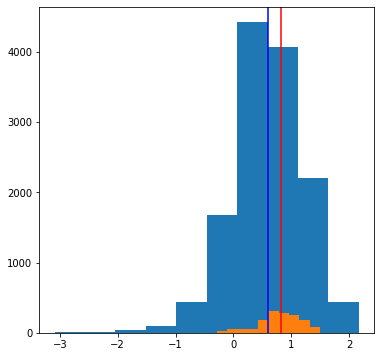

In [134]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(np.log10(S_F_Ha/eS_F_Ha)[S_Mstar>0])#,bins=np.linspace(-3.1,2.2,31))
ax.hist(np.log10(S_F_Ha_rep/eS_F_Ha_rep)[S_Mstar_rep>0])#,bins=np.linspace(-3.1,2.2,31))
ax.axvline(np.nanmedian(np.log10(S_F_Ha/eS_F_Ha)[S_Mstar>0]),c='b')
ax.axvline(np.nanmedian(np.log10(S_F_Ha_rep/eS_F_Ha_rep)[S_Mstar_rep>0]),c='r')
plt.show()

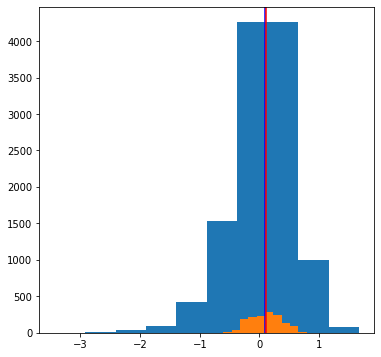

In [144]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(np.log10(F_Hb/eF_Hb)[S_Mstar>0])#,bins=np.linspace(-3.1,2.2,31))
ax.hist(np.log10(F_Hb_rep/eF_Hb_rep)[S_Mstar_rep>0])#,bins=np.linspace(-3.1,2.2,31))
ax.axvline(np.nanmedian(np.log10(F_Hb/eF_Hb)[S_Mstar>0]),c='b')
ax.axvline(np.nanmedian(np.log10(F_Hb_rep/eF_Hb_rep)[S_Mstar_rep>0]),c='r')
plt.show()

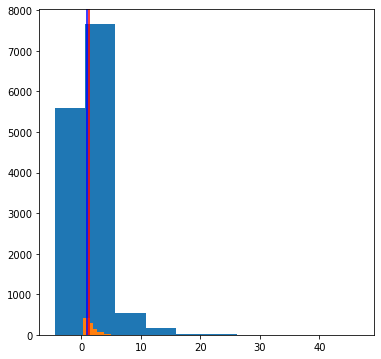

In [145]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist((F_Hb/eF_Hb)[S_Mstar>0])#,bins=np.linspace(-3.1,2.2,31))
ax.hist((F_Hb_rep/eF_Hb_rep)[S_Mstar_rep>0])#,bins=np.linspace(-3.1,2.2,31))
ax.axvline(np.nanmedian((F_Hb/eF_Hb)[S_Mstar>0]),c='b')
ax.axvline(np.nanmedian((F_Hb_rep/eF_Hb_rep)[S_Mstar_rep>0]),c='r')
plt.show()

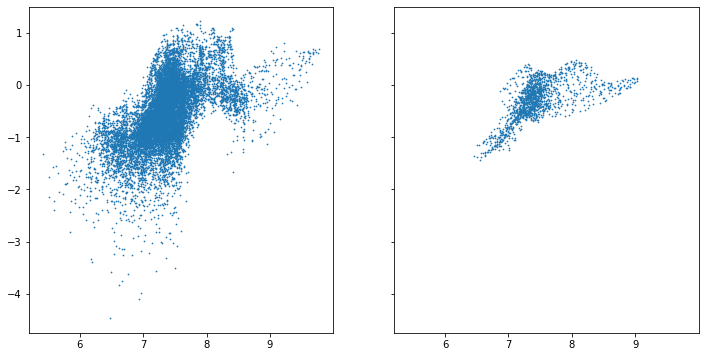

In [65]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharex='row',sharey='row')
ax[0].scatter(np.log10(S_Mstar),np.log10(S_F_Ha),s=0.5)
ax[1].scatter(np.log10(S_Mstar_rep),np.log10(S_F_Ha_rep),s=0.5)
plt.show()

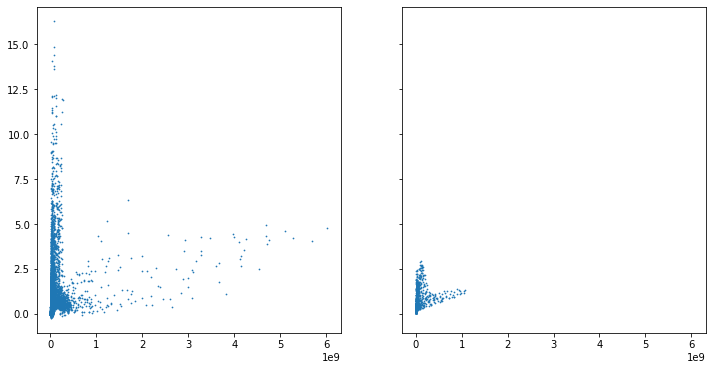

In [66]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharex='row',sharey='row')
ax[0].scatter(S_Mstar,S_F_Ha,s=0.5)
ax[1].scatter(S_Mstar_rep,S_F_Ha_rep,s=0.5)
plt.show()

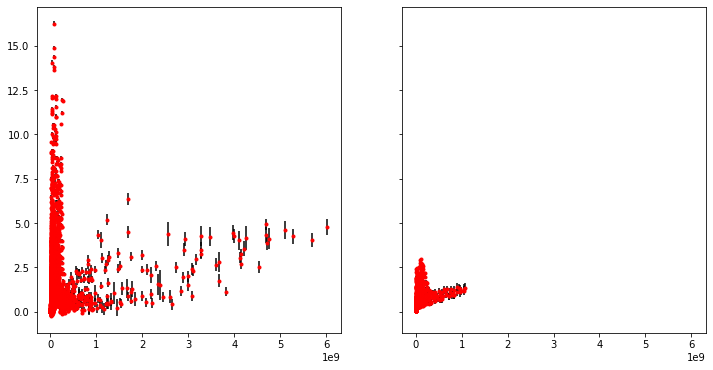

In [102]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharex='row',sharey='row')
ax[0].errorbar(S_Mstar.flatten(),S_F_Ha.flatten(),xerr=eS_Mstar.flatten(),yerr=eS_F_Ha.flatten(),fmt='.',mfc='r',mec='r',ecolor='k')
ax[1].errorbar(S_Mstar_rep.flatten(),S_F_Ha_rep.flatten(),xerr=eS_Mstar_rep.flatten(),yerr=eS_F_Ha_rep.flatten(),fmt='.',mfc='r',mec='r',ecolor='k')
#ax[1].scatter(S_Mstar_rep,S_F_Ha_rep,s=0.5)
plt.show()

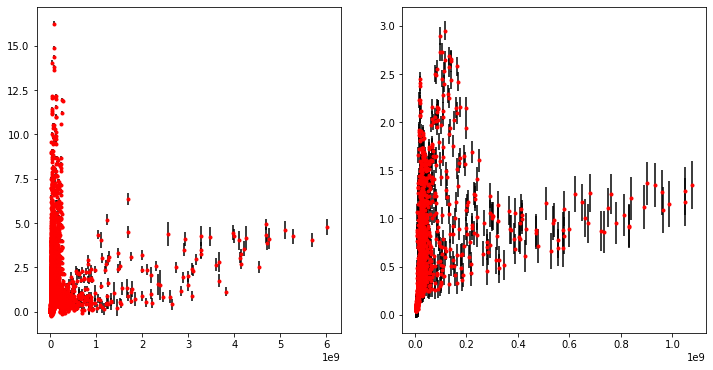

In [189]:
fig,ax = plt.subplots(1,2,figsize=(12,6))#,sharex='row',sharey='row')
ax[0].errorbar(S_Mstar.flatten(),S_F_Ha.flatten(),xerr=eS_Mstar.flatten(),yerr=eS_F_Ha.flatten(),fmt='.',mfc='r',mec='r',ecolor='k')
ax[1].errorbar(S_Mstar_rep.flatten(),S_F_Ha_rep.flatten(),xerr=eS_Mstar_rep.flatten(),yerr=eS_F_Ha_rep.flatten(),fmt='.',mfc='r',mec='r',ecolor='k')
#ax[1].scatter(S_Mstar_rep,S_F_Ha_rep,s=0.5)
plt.show()

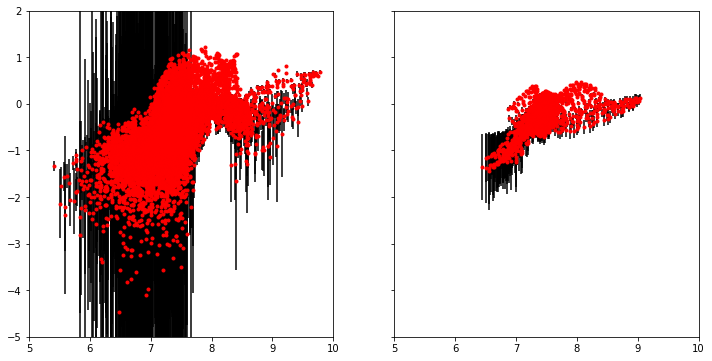

In [104]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharex='row',sharey='row')

x = np.log10(S_Mstar.flatten())
y = np.log10(S_F_Ha.flatten())
xerr = (eS_Mstar/S_Mstar).flatten()/np.log(10)
yerr = (eS_F_Ha/S_F_Ha).flatten()/np.log(10)
ax[0].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.',mfc='r',mec='r',ecolor='k')
ax[0].set_xlim(5,10)
ax[0].set_ylim(-5,2)

x = np.log10(S_Mstar_rep.flatten())
y = np.log10(S_F_Ha_rep.flatten())
xerr = (eS_Mstar_rep/S_Mstar_rep).flatten()/np.log(10)
yerr = (eS_F_Ha_rep/S_F_Ha_rep).flatten()/np.log(10)
ax[1].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.',mfc='r',mec='r',ecolor='k')
ax[1].set_xlim(5,10)
ax[1].set_ylim(-5,2)
#ax[1].scatter(S_Mstar_rep,S_F_Ha_rep,s=0.5)
plt.show()

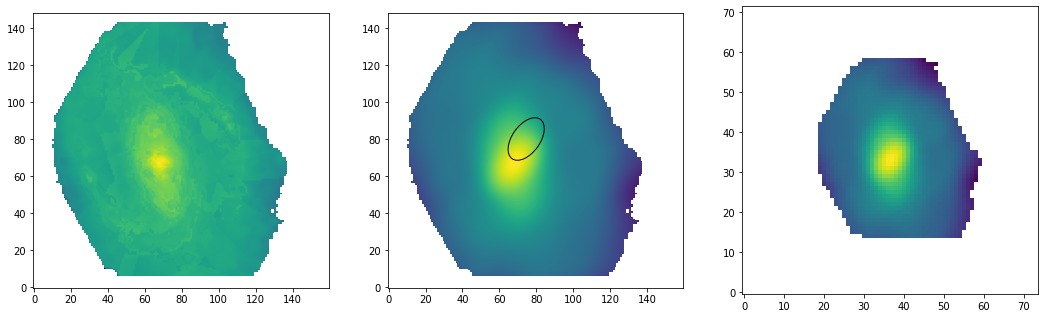

In [62]:
fig,axs = plt.subplots(1,3,figsize=(18,7))
for ax, frame in zip(axs.ravel(),[np.log10(Mstar),np.log10(frames_cube_convolved[0]),np.log10(Mstar_rep)]):
    ax.imshow(frame,origin='lower')
ell = Ellipse(xy=(Mstar.shape[0]/2,Mstar.shape[1]/2), width=10000*beam_aca.minor.value, height=10000*beam_aca.major.value, angle=beam_aca.pa.value, color='black')
ell.set_facecolor('none')
axs[1].add_artist(ell)
plt.show()    

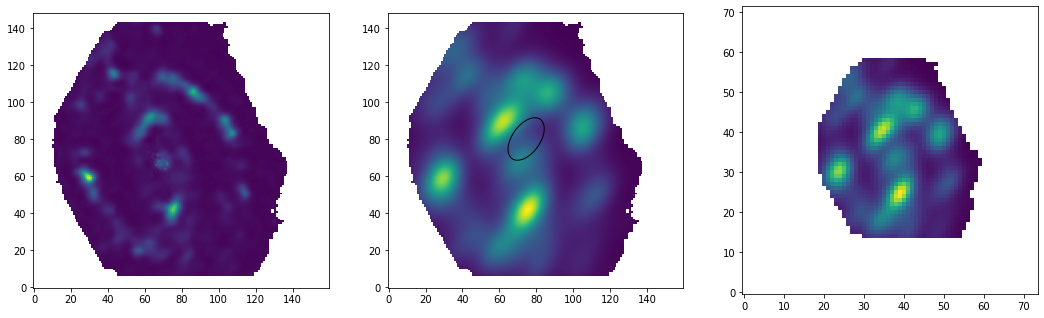

In [147]:
fig,axs = plt.subplots(1,3,figsize=(18,7))
for ax, frame in zip(axs.ravel(),[F_Ha,frames_cube_convolved[1],F_Ha_rep]):
    ax.imshow(frame,origin='lower')
ell = Ellipse(xy=(Mstar.shape[0]/2,Mstar.shape[1]/2), width=10000*beam_aca.minor.value, height=10000*beam_aca.major.value, angle=beam_aca.pa.value, color='black')
ell.set_facecolor('none')
axs[1].add_artist(ell)
plt.show()    

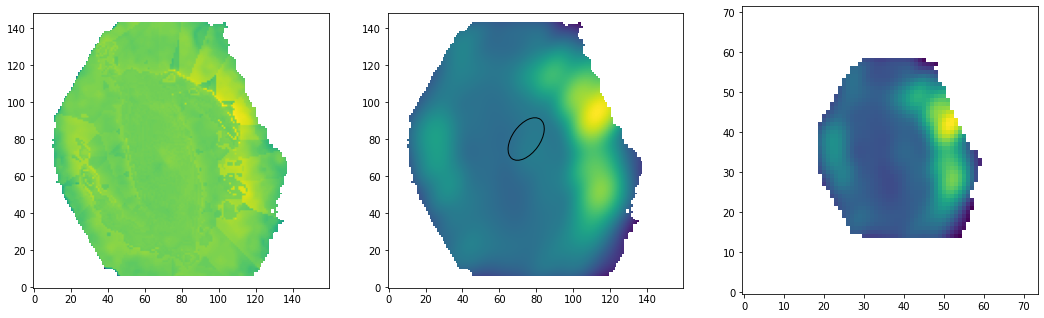

In [114]:
fig,axs = plt.subplots(1,3,figsize=(18,7))
for ax, frame in zip(axs.ravel(),[np.log10(eMstar),np.log10(frames_cube_convolved[2]),np.log10(eMstar_rep)]):
    ax.imshow(frame,origin='lower')
ell = Ellipse(xy=(Mstar.shape[0]/2,Mstar.shape[1]/2), width=10000*beam_aca.minor.value, height=10000*beam_aca.major.value, angle=beam_aca.pa.value, color='black')
ell.set_facecolor('none')
axs[1].add_artist(ell)
plt.show()    

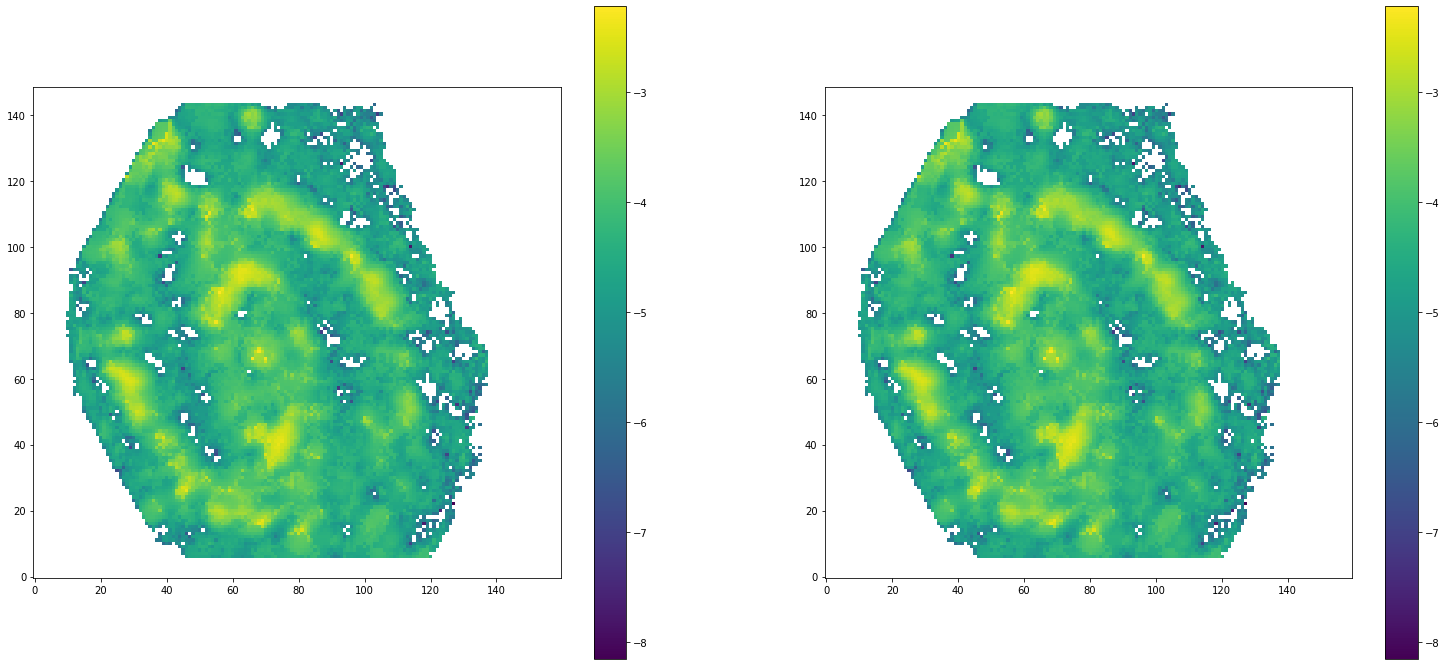

In [180]:
Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86)
Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
Ha_to_Hb_median = np.nanmedian(Ha_to_Hb[(Ha_to_Hb>2.86)&(F_Hb>eF_Hb)])
Ha_to_Hb = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),Ha_to_Hb_median,Ha_to_Hb)

A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
SFR = 7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value*F_Ha*np.power(10,A_Ha/2.5)

ratio = 5.86/2.5
SFR_test = 7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value*np.where(Ha_to_Hb>2.86,(2.86**-ratio)*np.power(Ha_to_Hb,ratio)*F_Ha,F_Ha)

fig,axs = plt.subplots(1,2,figsize=(26,12))
for ax, frame in zip(axs.ravel(),[SFR,SFR_test]):
    im = ax.imshow(np.log10(frame),origin='lower')
    fig.colorbar(im,ax=ax)

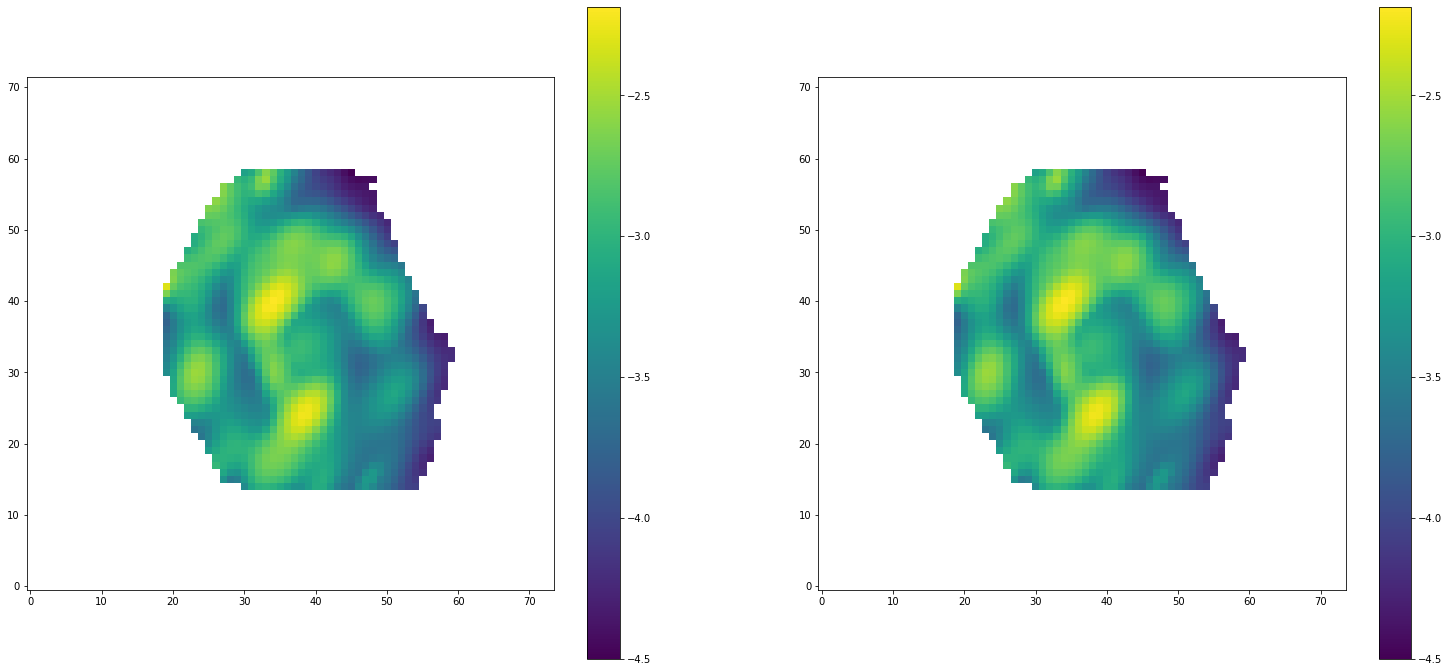

In [193]:
Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86)
Ha_to_Hb_rep = np.where(F_Ha_rep>0,Ha_to_Hb_rep,np.nan)
Ha_to_Hb_median_rep = np.nanmedian(Ha_to_Hb_rep[(Ha_to_Hb_rep>2.86)])
Ha_to_Hb_rep = np.where(np.isnan(F_Hb_rep)&(F_Ha_rep>0),Ha_to_Hb_median_rep,Ha_to_Hb_rep)

A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
SFR_rep = 7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value*F_Ha_rep*np.power(10,A_Ha_rep/2.5)

ratio = 5.86/2.5
SFR_test_rep = 7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value*np.where(Ha_to_Hb_rep>2.86,(2.86**-ratio)*np.power(Ha_to_Hb_rep,ratio)*F_Ha_rep,F_Ha_rep)

fig,axs = plt.subplots(1,2,figsize=(26,12))
for ax, frame in zip(axs.ravel(),[SFR_rep,SFR_test_rep]):
    im = ax.imshow(np.log10(frame),origin='lower')
    fig.colorbar(im,ax=ax)

In [194]:
print(np.nansum(SFR_test),np.nansum(SFR_test_rep))

2.1032203570442234 1.4741320593253002


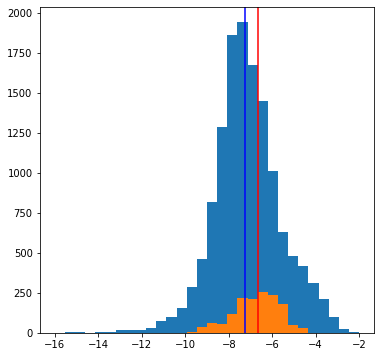

In [186]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(np.log(SFR_test/pix_area_califa.value)[S_Mstar>0],bins=np.linspace(-16,-2,31))
ax.hist(np.log(SFR_test_rep/pix_area_aca.value)[S_Mstar_rep>0],bins=np.linspace(-16,-2,31))
ax.axvline(np.nanmedian(np.log(SFR_test/pix_area_califa.value)[S_Mstar>0]),c='b')
ax.axvline(np.nanmedian(np.log(SFR_test_rep/pix_area_aca.value)[S_Mstar_rep>0]),c='r')
plt.show()

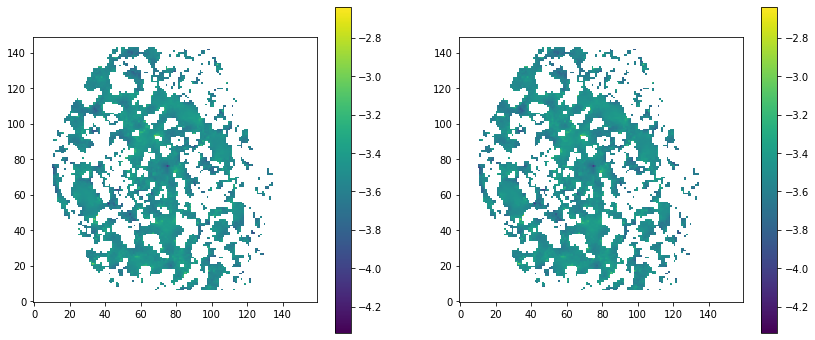

In [197]:

O3N2 = np.log10(Ha_to_Hb*F_OIII/F_NII)
Z_O3N2 = np.power(10,-12+8.533-0.214*O3N2)

#ratio = 5.86/2.5
Z_O3N2_test = 10**(-12+8.533)*(Ha_to_Hb*F_OIII/F_NII)**-0.214

fig,axs = plt.subplots(1,2,figsize=(14,6))
for ax, frame in zip(axs.ravel(),[Z_O3N2,Z_O3N2_test]):
    im = ax.imshow(np.log10(frame),origin='lower')
    fig.colorbar(im,ax=ax)

In [38]:
#Database = []
#for n,source in enumerate(sources[:]):
    #print(f'\nInitializing source {n+1} of {len(sources)}:',source)
source = 'UGC12250'
z = aca_table.loc[source,'z_stars']
inc = aca_table.loc[source,'inclination_califa']
cos = np.cos(np.deg2rad(inc))
PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
D_lum = cosmo.luminosity_distance(z)
D_ang = cosmo.angular_diameter_distance(z)
Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
hs = Re/(1.68*7.3) # disc scale height in kpc
QS = aca_table.loc[source,'Final_QS']
NA = aca_table.loc[source,'Final_NA']
    
    # Deprojecting inclination effects
reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
mom0 = reduced_cube.moment(order=0)
dec, ra = mom0.world[:]
ra = ra.value
dec = dec.value
rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
#    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    #CO_int = np.where(np.log10(CO_vdisp)>-1,CO_int,np.nan)
    #CO_vdisp = np.where(np.log10(CO_vdisp)>-1,CO_vdisp,np.nan)
    
Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
eMstar, califa_hdr = get_data(califaoutpath+source+'_eMstar.fits',header=True)
region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
F_NII = get_data(califaoutpath+source+'_F_NII.fits')
F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
#    D4000 = get_data(califaoutpath+source+'_D4000.fits')
califa_hdr3D['NAXIS1'] = 0
califa_hdr3D['NAXIS2'] = 0

BPT_mask = ((0.61/(np.log10(F_NII/F_Ha)-0.47)+1.19)>np.log10(F_OIII/F_Hb))&(np.log10(F_NII/F_Ha)<0.47)
final_mask = BPT_mask&Ha_mask
    # defining beam properties for convolution
fwhm_califa = 1.65
fwhm_aca = 6.
beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    #beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
beam_aca = reduced_cube.beam
    
#    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
#    Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
#    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
#    A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
#    A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
#    SFR = 7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    # 1.6 factor converts from Salpeter IMF to Kroupa IMF
    #SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
      
    
    # convolving CALIFA mpas to ACA resolution
#frames_cube = SpectralCube(data=np.array([Mstar,F_NII,F_OIII,F_Ha,F_Hb,SFR,SFR_D4]),wcs=WCS(califa_hdr3D))
frames_cube = SpectralCube(data=np.array([Mstar,F_Ha,F_Hb,
                                          eMstar**2,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
frames_cube = frames_cube.with_mask(region)
frames_cube = frames_cube.with_beam(beam_califa)
frames_cube_convolved = frames_cube.convolve_to(beam_aca)
frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])

#frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])
frames_cube_convolved[-3:] = np.sqrt(frames_cube_convolved[-3:])


area_factor = pix_area_aca.value/pix_area_califa.value
reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
BPT_mask_rep = reproject_exact((BPT_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
final_mask_rep = reproject_exact((final_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
#D4_mask_rep = reproject_exact((D4_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
final_mask_rep2 = (Ha_mask_rep==1)&(BPT_mask_rep==1)&1

[Mstar_rep,F_Ha_rep,F_Hb_rep,eMstar_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
#Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
#Ha_to_Hb_rep = np.where(F_Ha_rep>0,Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
#A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
#A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
#A_Ha_rep = np.where(np.isnan(F_Hb_rep)&(F_Ha_rep>0),A_Ha_median_rep,A_Ha_rep)
    
    #SFR_rep = 1.6*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    #SFR_rep = 7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    #R_21_rep = S_SFR_rep**0.1
    #R_21_rep = (S_SFR_rep1**0.12)*(10**-0.06)
    
S_Mstar_rep = Mstar_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
S_Mstar     = Mstar*cos/pix_area_califa.value
S_F_Ha_rep  = F_Ha_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
S_F_Ha      = F_Ha*cos/pix_area_califa.value

eS_Mstar_rep = eMstar_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
eS_Mstar     = eMstar*cos/pix_area_califa.value
eS_F_Ha_rep  = eF_Ha_rep*cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
eS_F_Ha      = eF_Ha*cos/pix_area_califa.value

#    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
#    S_SFR_rep2  = SFR_rep2 *cos/pix_area_aca.value
#    S_SFR_D4_rep = SFR_D4_rep*cos/pix_area_aca.value


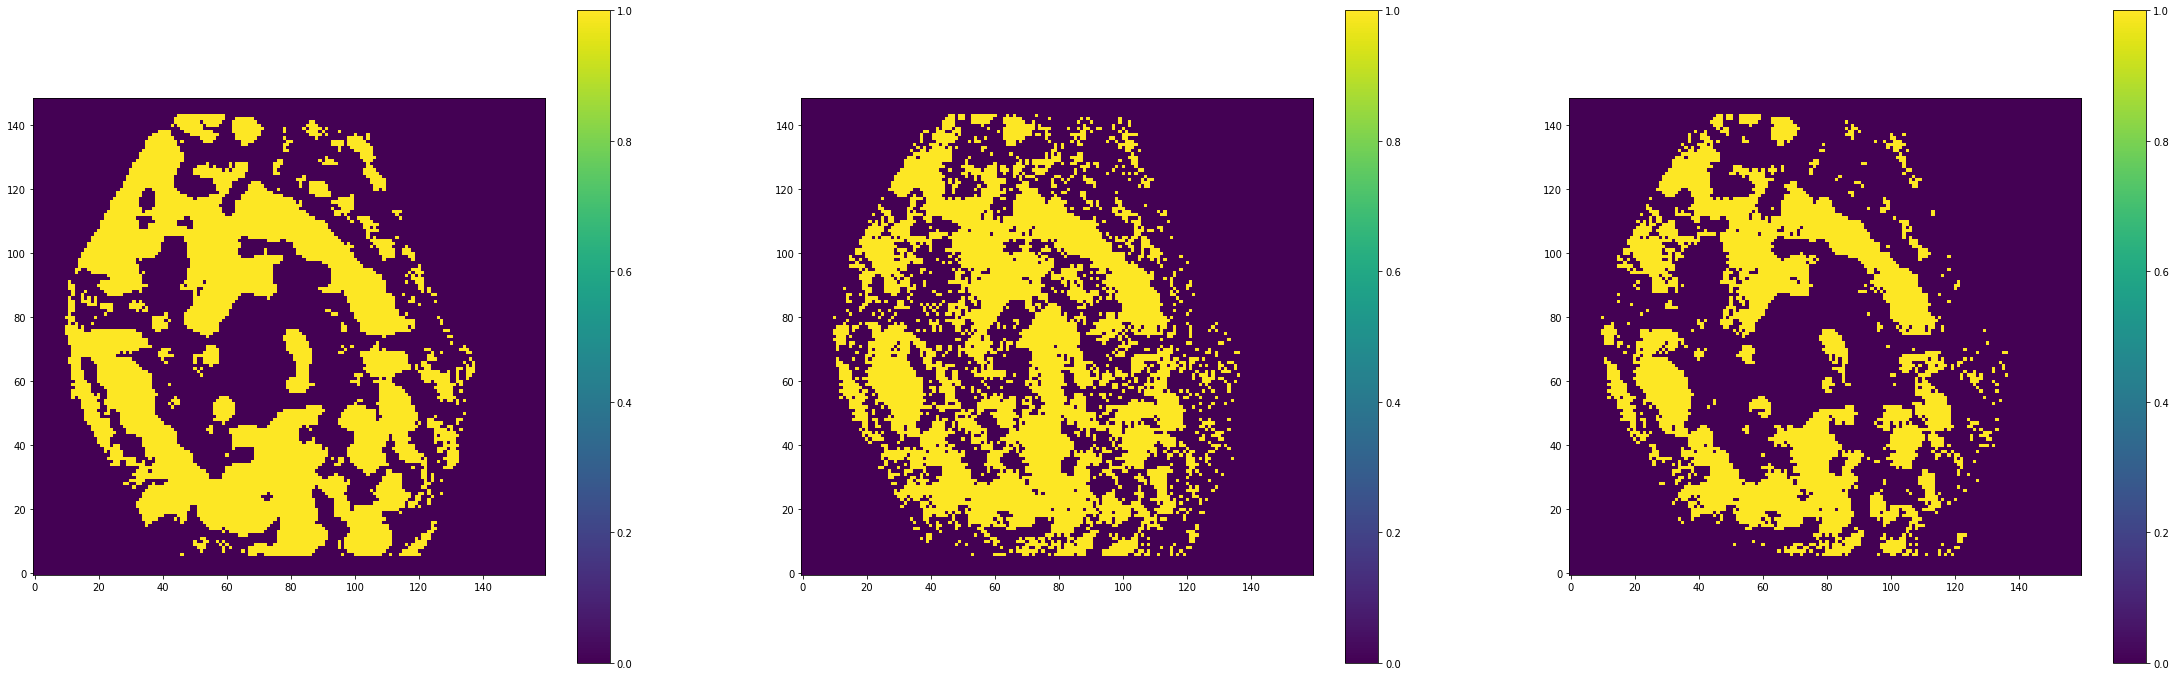

In [30]:
fig,axs = plt.subplots(1,3,figsize=(39,12))
for ax, frame in zip(axs.ravel(),[Ha_mask,BPT_mask,final_mask]):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax)

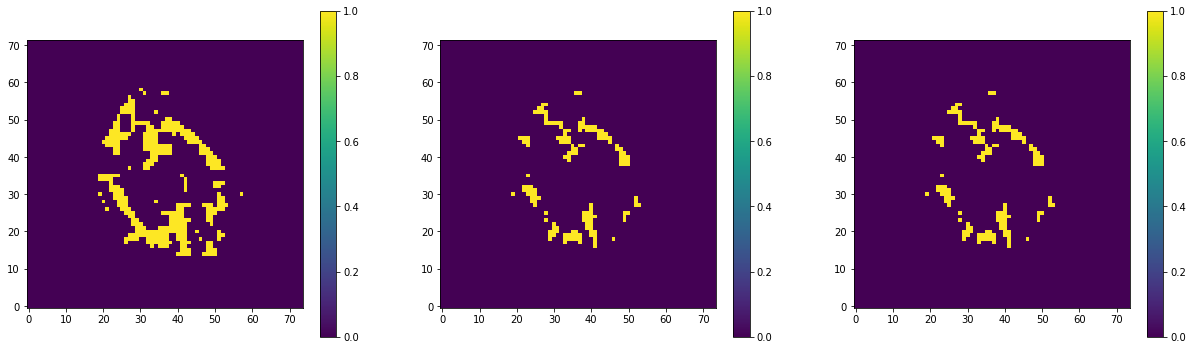

In [39]:
fig,axs = plt.subplots(1,3,figsize=(21,6))
for ax, frame in zip(axs.ravel(),[Ha_mask_rep==1,final_mask_rep==1,final_mask_rep2]):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax)

In [21]:
Database = []
for n,source in enumerate(sources[:]):
    print(f'\nInitializing source {n+1} of {len(sources)}:',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    
    # Deprojecting inclination effects
    reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    mom0 = reduced_cube.moment(order=0)
    dec, ra = mom0.world[:]
    ra  = ra.value
    dec = dec.value
    rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    eCO_int = get_data(acaoutpath+source+'_integrated_unc.fits')
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    #CO_int = np.where(np.log10(CO_vdisp)>-1,CO_int,np.nan)
    #CO_vdisp = np.where(np.log10(CO_vdisp)>-1,CO_vdisp,np.nan)
    
    Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    eMstar = get_data(califaoutpath+source+'_eMstar.fits')
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    eF_NII = get_data(califaoutpath+source+'_F_NII.fits')
    eF_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    D4000 = get_data(califaoutpath+source+'_D4000.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0
    
    BPT_mask = ((0.61/(np.log10(F_NII/F_Ha)-0.47)+1.19)>np.log10(F_OIII/F_Hb))&(np.log10(F_NII/F_Ha)<0.47)
    SF_mask = BPT_mask&Ha_mask

    # defining beam properties for convolution
    fwhm_califa = 1.65
    fwhm_aca = 6.
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    #beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    beam_aca = reduced_cube.beam
    
    flux2SFR = 7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value
    # 1.6 factor converts from Salpeter IMF to Kroupa IMF:
    #flux2SFR = 1.6*7.9*(10**-(42+16))*4*np.pi*(D_lum**2).to(u.cm**2).value
    
    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
    A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
    ratio = 5.86/2.5
    SFR2 = flux2SFR*F_Ha*np.power(10,A_Ha/2.5)
    eSFR2 = np.where(Ha_to_Hb>2.86,SFR2*np.sqrt((ratio*eF_Hb/F_Hb)**2 + ((1+ratio)*eF_Ha/F_Ha)**2),flux2SFR*eF_Ha)
    
    D4_mask = (D4000>=D4000_min)&(D4000<D4000_max)
    D4000_binned = D4000.copy()
    D4000_binned = create_bins(D4000_binned,D4_binwidth)
    D4000_binned = np.trunc(D4000_binned*100)/100
    D4000_binned = np.where(D4000_binned<D4000_min,np.nan,D4000_binned)
    #D4000_binned = np.where(D4000_binned>=D4000_max,np.nan,D4000_binned)
    D4000_binned = np.where(D4000_binned>=D4000_max,D4000_max,D4000_binned)
    sSFR_D4 = np.array([[D4000_sSFR.loc[element,'sSFR_D4'] if ~np.isnan(element) else np.nan for element in row] for row in D4000_binned])
    SFR_D4  = sSFR_D4*Mstar
    esSFR_D4 = np.array([[D4000_sSFR.loc[element,'sSFR_D4_uncl'] if ~np.isnan(element) else np.nan for element in row] for row in D4000_binned])
    eSFR_D4  = np.sqrt( (esSFR_D4*Mstar)**2 + (sSFR_D4*eMstar)**2 )
        
    # convolving CALIFA mpas to ACA resolution (error maps squared before convolution)
    frames_cube = SpectralCube(data=np.array([Mstar,F_Ha,F_Hb,F_NII,F_OIII,SFR2,SFR_D4,
                                              eMstar**2,eF_Ha**2,eF_Hb**2,eF_NII**2,eF_OIII**2,eSFR2**2,eSFR_D4**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    frames_cube_convolved[-7:] = np.sqrt(frames_cube_convolved[-7:]) # taking square root of convolved errors
    
    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    SF_mask_rep = reproject_exact((SF_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    D4_mask_rep = reproject_exact((D4_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [Mstar_rep,F_Ha_rep,F_Hb_rep,F_NII_rep,F_OIII_rep,SFR_rep2,SFR_D4_rep,
     eMstar_rep,eF_Ha_rep,eF_Hb_rep,eF_NII_rep,eF_OIII_rep,eSFR_rep2,eSFR_D4_rep] = reprojected_list
    
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(F_Ha_rep>0,Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
    Ha_to_Hb_median_rep = np.nanmedian(Ha_to_Hb_rep[(Ha_to_Hb_rep>2.86)])
    Ha_to_Hb_rep = np.where(np.isnan(F_Hb_rep)&(F_Ha_rep>0),Ha_to_Hb_median_rep,Ha_to_Hb_rep)
    #A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    #SFR_rep = flux2SFR*F_Ha_rep*np.power(10,A_Ha_rep/2.5)
    ratio = 5.86/2.5
    SFR_rep = flux2SFR*np.where(Ha_to_Hb_rep>2.86,(2.86**-ratio)*np.power(Ha_to_Hb_rep,ratio)*F_Ha_rep,F_Ha_rep)
    eSFR_rep = np.where(Ha_to_Hb_rep>2.86,SFR_rep*np.sqrt((ratio*eF_Hb_rep/F_Hb_rep)**2 + ((1+ratio)*eF_Ha_rep/F_Ha_rep)**2),flux2SFR*eF_Ha_rep)
    
    S_Mstar_rep  = Mstar_rep *cos/pix_area_aca.value # stellar mass surface density in M_sun pc^-2
    eS_Mstar_rep = eMstar_rep*cos/pix_area_aca.value
    S_SFR_rep     = SFR_rep    *cos/pix_area_aca.value #        SFR surface density in M_sun pc^-2 yr^-1
    eS_SFR_rep    = eSFR_rep   *cos/pix_area_aca.value
    S_SFR_rep2    = SFR_rep2   *cos/pix_area_aca.value
    eS_SFR_rep2   = eSFR_rep2  *cos/pix_area_aca.value
    S_SFR_D4_rep  = SFR_D4_rep *cos/pix_area_aca.value
    eS_SFR_D4_rep = eSFR_D4_rep*cos/pix_area_aca.value
    
    # from Bolatto et al. 2017 and Marino et al. 2013:
    #O3N2_rep = np.log10(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))
    #N2_rep = np.log10(F_NII_rep/F_Ha_rep)
    #Z_O3N2_rep = np.power(10,-12 + 8.533 - 0.214*O3N2_rep)/Z_sun
    #Z_N2_rep   = np.power(10,-12 + 8.743 + 0.462*N2_rep)/Z_sun
    Z_O3N2_rep = (10**(-12+8.533)*(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))**-0.214)/Z_sun
    Z_N2_rep   = (10**(-12+8.743)*(F_NII_rep/F_Ha_rep)**+0.462)/Z_sun
    eZ_O3N2_rep = Z_O3N2_rep*0.214*np.sqrt((eF_Ha_rep/F_Ha_rep)**2+(eF_Hb_rep/F_Hb_rep)**2+(eF_OIII_rep/F_OIII_rep)**2+(eF_NII_rep/F_NII_rep)**2)
    eZ_N2_rep   = Z_N2_rep*0.462*np.sqrt((eF_Ha_rep/F_Ha_rep)**2+(eF_NII_rep/F_NII_rep)**2)
    # from Bolatto et al. 2013
    S_GMC = 1
    # using 10^8 instead of 100 because S_Mstar is in M_sun kpc^-2 instead of M_sun pc^-2
    alphaCO_O3N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_O3N2_rep))*np.power(S_Mstar_rep/10**8,np.where(S_Mstar_rep>10**8,-0.5,0))
    alphaCO_N2_rep   = 2.9*np.exp(0.4/(S_GMC*Z_N2_rep))*np.power(S_Mstar_rep/10**8,np.where(S_Mstar_rep>10**8,-0.5,0))
    ealphaCO_O3N2_rep = alphaCO_O3N2_rep*np.where(S_Mstar_rep>10**8,np.sqrt((eZ_O3N2_rep*0.4/(S_GMC*Z_O3N2_rep**2))**2 + (0.5*eS_Mstar_rep/S_Mstar_rep)**2),eZ_O3N2_rep*0.4/(S_GMC*Z_O3N2_rep**2))
    ealphaCO_N2_rep   = alphaCO_N2_rep*np.where(S_Mstar_rep>10**8,np.sqrt((eZ_N2_rep*0.4/(S_GMC*Z_N2_rep**2))**2 + (0.5*eS_Mstar_rep/S_Mstar_rep)**2),eZ_N2_rep*0.4/(S_GMC*Z_N2_rep**2))
    
    smoothmask = get_data(acaoutpath+source+'_smoothmask.fits')
    nchannels = np.sum(smoothmask,axis=0)
    
    flat_region = Mstar_rep.flatten()>0

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Final_QS':np.broadcast_to(QS,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Final_NA':np.broadcast_to(NA,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_Mstar_rep.flatten().shape)[flat_region],
                                     'PA':np.broadcast_to(PA,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Area_kpc2':np.broadcast_to(pix_area_aca.value/cos,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Re_kpc':np.broadcast_to(Re,S_Mstar_rep.flatten().shape)[flat_region],
                                     'Rgal_kpc':rgrid.flatten()[flat_region],
                                     'RA': ra.flatten()[flat_region],
                                     'DEC':dec.flatten()[flat_region],
                                     'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':  S_Mstar_rep.flatten()[flat_region],
                                     'eS_Mstar': eS_Mstar_rep.flatten()[flat_region],
                                     'S_SFR':    S_SFR_rep.flatten()[flat_region],
                                     'eS_SFR':   eS_SFR_rep.flatten()[flat_region],
                                     'S_SFR2':   S_SFR_rep2.flatten()[flat_region],
                                     'eS_SFR2':  eS_SFR_rep2.flatten()[flat_region],
                                     'S_SFR_D4': S_SFR_D4_rep.flatten()[flat_region],
                                     'eS_SFR_D4':eS_SFR_D4_rep.flatten()[flat_region],
                                     'Ha_mask':Ha_mask_rep.flatten()[flat_region],
                                     'SF_mask':SF_mask_rep.flatten()[flat_region],
                                     'D4_mask':D4_mask_rep.flatten()[flat_region],
                                     'Z_O3N2': Z_O3N2_rep.flatten()[flat_region],
                                     'eZ_O3N2':eZ_O3N2_rep.flatten()[flat_region],
                                     'Z_N2':   Z_N2_rep.flatten()[flat_region],
                                     'eZ_N2':  eZ_N2_rep.flatten()[flat_region],
                                     'alphaCO_O3N2': alphaCO_O3N2_rep.flatten()[flat_region],
                                     'ealphaCO_O3N2':ealphaCO_O3N2_rep.flatten()[flat_region],
                                     'alphaCO_N2':   alphaCO_N2_rep.flatten()[flat_region],
                                     'ealphaCO_N2':  ealphaCO_N2_rep.flatten()[flat_region],
                                     'CO_int': CO_int.flatten()[flat_region],
                                     'eCO_int':eCO_int.flatten()[flat_region],
                                     'CO_nchannels':nchannels.flatten()[flat_region],
                                     'CO_vdisp':CO_vdisp.flatten()[flat_region]})
    Database.append(Partial_Database)


Initializing source 1 of 40: CGCG429-012

Initializing source 2 of 40: IC1079

Initializing source 3 of 40: IC1528

Initializing source 4 of 40: IC2341


/users/brodriguez/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Initializing source 5 of 40: MCG-01-52-012

Initializing source 6 of 40: MCG-02-02-030

Initializing source 7 of 40: NGC0001

Initializing source 8 of 40: NGC0155

Initializing source 9 of 40: NGC0171

Initializing source 10 of 40: NGC0180

Initializing source 11 of 40: NGC0693

Initializing source 12 of 40: NGC0731

Initializing source 13 of 40: NGC0768

Initializing source 14 of 40: NGC1056

Initializing source 15 of 40: NGC1542

Initializing source 16 of 40: NGC2449

Initializing source 17 of 40: NGC2540

Initializing source 18 of 40: NGC2554

Initializing source 19 of 40: NGC2595

Initializing source 20 of 40: NGC3300

Initializing source 21 of 40: NGC7025

Initializing source 22 of 40: NGC7194

Initializing source 23 of 40: NGC7311

Initializing source 24 of 40: NGC7321

Initializing source 25 of 40: NGC7364

Initializing source 26 of 40: NGC7466

Initializing source 27 of 40: NGC7489

Initializing source 28 of 40: NGC7625

Initializing source 29 of 40: NGC7716

Initializing sour

In [22]:
Database = pd.concat(Database,ignore_index=True)
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67869 entries, 0 to 67868
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Source         67869 non-null  object 
 1   Final_QS       67869 non-null  object 
 2   Final_NA       67869 non-null  object 
 3   Inclination    67869 non-null  float64
 4   PA             67869 non-null  float64
 5   Area_kpc2      67869 non-null  float64
 6   Re_kpc         67869 non-null  float64
 7   Rgal_kpc       67869 non-null  float64
 8   RA             67869 non-null  float64
 9   DEC            67869 non-null  float64
 10  T_gal          67869 non-null  float64
 11  S_Mstar        67869 non-null  float64
 12  eS_Mstar       67869 non-null  float64
 13  S_SFR          67869 non-null  float64
 14  eS_SFR         67869 non-null  float64
 15  S_SFR2         67869 non-null  float64
 16  eS_SFR2        67869 non-null  float64
 17  S_SFR_D4       67869 non-null  float64
 18  eS_SFR

In [23]:
Database.to_csv(databasepath+'ACA_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

In [25]:
Database['log_S_SFR'] = np.log10(Database['S_SFR'])
Database['log_S_SFR2'] = np.log10(Database['S_SFR2'])
Database['log_S_SFR_D4'] = np.log10(Database['S_SFR_D4'])

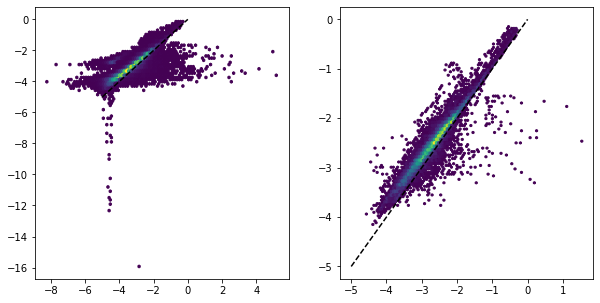

In [27]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hexbin(Database['log_S_SFR'],Database['log_S_SFR2'],mincnt=1)
axs[1].hexbin(Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR'],Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR2'],mincnt=1)
axs[0].plot([-5,0],[-5,0],c='k',ls='--')
axs[1].plot([-5,0],[-5,0],c='k',ls='--')
plt.show()

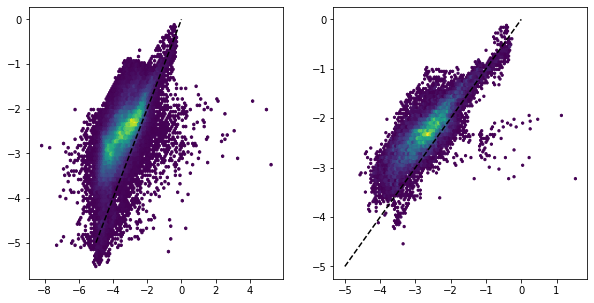

In [28]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hexbin(Database['log_S_SFR'],Database['log_S_SFR_D4'],mincnt=1)
axs[1].hexbin(Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR'],Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR_D4'],mincnt=1)
axs[0].plot([-5,0],[-5,0],c='k',ls='--')
axs[1].plot([-5,0],[-5,0],c='k',ls='--')
plt.show()

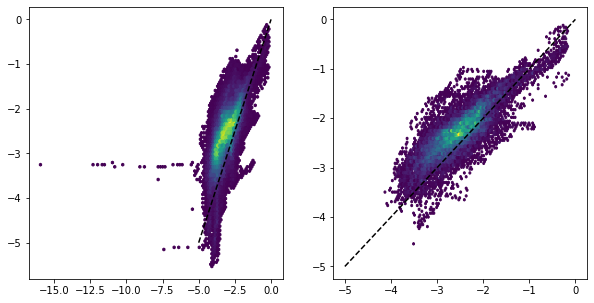

In [29]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hexbin(Database['log_S_SFR2'],Database['log_S_SFR_D4'],mincnt=1)
axs[1].hexbin(Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR2'],Database.loc[np.floor(Database['Ha_mask'])==1,'log_S_SFR_D4'],mincnt=1)
axs[0].plot([-5,0],[-5,0],c='k',ls='--')
axs[1].plot([-5,0],[-5,0],c='k',ls='--')
plt.show()

In [280]:
Database = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    #print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    mom0 = reduced_cube.moment(order=0)
    dec, ra = mom0.world[:]
    ra = ra.value
    dec = dec.value
    rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    M_star *= 1.6
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0

    # convolving CALIFA mpas to ACA resolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    ppbeam_califa = (fwhm_califa/pix_scale_califa/2)**2 / np.log(2)*np.pi
    ppbeam_aca = (fwhm_aca/pix_scale_aca/2)**2 / np.log(2)*np.pi
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])*np.sqrt(ppbeam_califa/ppbeam_aca)
    frames_cube_convolved[-2] = np.sqrt(frames_cube_convolved[-2])*np.sqrt(ppbeam_califa/ppbeam_aca)
    
    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = area_factor*np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
    
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    SFR_rep = 1.6*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    R_21_rep = S_SFR_rep**0.1
    
    # from Bolatto et al. 2017 and Marino et al. 2013:
    O3N2_rep = np.log10(F_OIII_rep*F_Ha_rep/(F_Hb_rep*F_NII_rep))
    N2_rep = np.log10(F_NII_rep/F_Ha_rep)
    Z_O3N2_rep = np.power(10,-12 + 8.533 - 0.214*O3N2_rep)/Z_sun
    Z_N2_rep = np.power(10,-12 + 8.743 + 0.462*N2_rep)/Z_sun
    
    # from Bolatto et al. 2013
    S_GMC = 1
    # using 10^8 instead of 100 because S_star is in M_sun kpc^-2 instead of M_sun pc^-2
    alphaCO_O3N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_O3N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    alphaCO_N2_rep = 2.9*np.exp(0.4/(S_GMC*Z_N2_rep))*np.power(S_star_rep/10**8,np.where(S_star_rep>10**8,-0.5,0))
    
    # 10^6 factor converts from pc^-2 in alpha_CO to kpc^-2
    #S_mol_MW  = CO_int*cos*alphaCO_MW      *10**6/R_21_rep
    S_mol_O3N2 = CO_int*cos*alphaCO_O3N2_rep*10**6/R_21_rep
    #S_mol_N2  = CO_int*cos*alphaCO_N2_rep  *10**6/R_21_rep
    
    # from Barrera-Ballesteros et al. 2021
    star_vdisp = np.sqrt(2*np.pi*G*S_star_rep*hs)*u.kpc.to(u.km) # stellar velocity dispersion in km s^-1
    # from Elmegreen et al. 1989
    Ph_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)*((S_mol_O3N2+S_H1)+S_star_rep*CO_vdisp/star_vdisp)
    Ph_rep = Ph_rep/k_B/(u.kpc**3).to(u.cm**3)
    # from Kim, Kim & Ostriker 2011 and Sun et al. 2020
    Pde_rep = (np.pi*G/2)*(S_mol_O3N2+S_H1)**2 + (S_mol_O3N2+S_H1)*np.sqrt(G*S_star_rep/hs/2)*CO_vdisp/u.kpc.to(u.km)
    Pde_rep = Pde_rep/k_B/(u.kpc**3).to(u.cm**3)
    
    f_CO_rep = S_mol_O3N2/S_star_rep
    sSFR_rep = SFR_rep/M_star_rep
    SFE_rep  = S_SFR_rep/S_mol_O3N2
    flat_region = np.where(M_star_rep.flatten()>0,True,False)

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_star_rep.flatten().shape)[flat_region],
                                     'Final_QS':np.broadcast_to(QS,S_star_rep.flatten().shape)[flat_region],
                                     'Final_NA':np.broadcast_to(NA,S_star_rep.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_star_rep.flatten().shape)[flat_region],
                                     'PA':np.broadcast_to(PA,S_star_rep.flatten().shape)[flat_region],
                                     'Re_kpc':np.broadcast_to(Re,S_star_rep.flatten().shape)[flat_region],
                                     'RA':ra.flatten()[flat_region],
                                     'DEC':dec.flatten()[flat_region],
                                     'Rgal_kpc':rgrid.flatten()[flat_region],
                                     'T_gal':tgrid.flatten()[flat_region],
                                     'S_Mstar':S_star_rep.flatten()[flat_region],
                                     'S_SFR':S_SFR_rep.flatten()[flat_region],
                                     'Ha_mask':Ha_mask_rep.flatten()[flat_region],
                                     'R_21':R_21_rep.flatten()[flat_region],
                                     'Z_O3N2':Z_O3N2_rep.flatten()[flat_region],
                                     'Z_N2':Z_N2_rep.flatten()[flat_region],
                                     'alphaCO_O3N2':alphaCO_O3N2_rep.flatten()[flat_region],
                                     'alphaCO_N2':alphaCO_N2_rep.flatten()[flat_region],
                                     'S_mol_O3N2':S_mol_O3N2.flatten()[flat_region],
                                     'CO_vdisp':CO_vdisp.flatten()[flat_region],
                                     'star_vdisp':star_vdisp.flatten()[flat_region],
                                     'f_CO':f_CO_rep.flatten()[flat_region],
                                     'sSFR':sSFR_rep.flatten()[flat_region],
                                     'SFE':SFE_rep.flatten()[flat_region],
                                     'P_h':Ph_rep.flatten()[flat_region],
                                     'P_DE':Pde_rep.flatten()[flat_region]})
    Database.append(Partial_Database)


Initializing source CGCG429-012
fR nonA

Initializing source IC1079
MX nonA

Initializing source IC1528
SF nonA

Initializing source IC2341
fR nonA

Initializing source MCG-01-01-012
MX nonA

Initializing source MCG-01-10-015
SF nonA

Initializing source MCG-01-52-012
nR nonA

Initializing source MCG-02-02-030
QnR sAGN

Initializing source MCG-02-51-004
SF nonA

Initializing source NGC0001
SF nonA

Initializing source NGC0155
fR nonA

Initializing source NGC0169
MX wAGN

Initializing source NGC0171
cQ nonA

Initializing source NGC0180
QnR nonA

Initializing source NGC0693
SF nonA

Initializing source NGC0731
fR nonA

Initializing source NGC0768
SF nonA

Initializing source NGC0955
nR nonA

Initializing source NGC1056
SF nonA

Initializing source NGC1542
MX nonA

Initializing source NGC2449
MX nonA

Initializing source NGC2540
SF nonA

Initializing source NGC2554
nR wAGN

Initializing source NGC2595
QnR nonA

Initializing source NGC3300
fR nonA

Initializing source NGC6427
fR nonA

Ini

In [281]:
Database = pd.concat(Database,ignore_index=True)
Database

,Source,Final_QS,Final_NA,Inclination,PA,Re_kpc,RA,DEC,Rgal_kpc,T_gal,...,alphaCO_O3N2,alphaCO_N2,S_mol_O3N2,CO_vdisp,star_vdisp,f_CO,sSFR,SFE,P_h,P_DE
0,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.209394,14.378665,12.518788,-2.541135,...,4.342843,3.992809,NaN,NaN,1.732646,NaN,1.427581e-11,NaN,NaN,NaN
1,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208964,14.378665,12.002631,-2.617069,...,4.662306,4.193988,NaN,NaN,1.796422,NaN,1.358039e-11,NaN,NaN,NaN
2,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208534,14.378665,11.561619,-2.699303,...,5.077261,4.663437,NaN,NaN,1.862751,NaN,1.673094e-11,NaN,NaN,NaN
3,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.208104,14.378665,11.204629,-2.787408,...,5.457726,5.266703,NaN,NaN,1.924607,NaN,2.147072e-11,NaN,NaN,NaN
4,CGCG429-012,fR,nonA,59.991884,6.449515,1.397272,339.207244,14.378665,10.774203,-2.977394,...,6.630550,6.229237,NaN,NaN,2.047223,NaN,2.043582e-11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87458,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.205560,-8.962386,29.284013,1.725595,...,6.223236,5.606821,NaN,NaN,2.900236,NaN,5.364717e-10,NaN,NaN,NaN
87459,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.205279,-8.962386,29.745294,1.733761,...,6.326578,5.701627,NaN,NaN,2.922467,NaN,5.843134e-10,NaN,NaN,NaN
87460,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.216246,-8.961830,16.989412,1.110715,...,5.349539,5.075181,NaN,NaN,4.504568,NaN,4.136860e-11,NaN,NaN,NaN
87461,VV488NED02,SF,nonA,73.160751,68.756316,3.143968,344.216246,-8.961552,18.008724,1.131169,...,5.247439,5.060841,NaN,NaN,4.596295,NaN,4.094734e-11,NaN,NaN,NaN


In [279]:
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87463 entries, 0 to 87462
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source        87463 non-null  object 
 1   Final_QS      87463 non-null  object 
 2   Final_NA      87463 non-null  object 
 3   Inclination   87463 non-null  float64
 4   PA            87463 non-null  float64
 5   Re_kpc        87463 non-null  float64
 6   RA            87463 non-null  float64
 7   DEC           87463 non-null  float64
 8   Rgal_kpc      87463 non-null  float64
 9   T_gal         87463 non-null  float64
 10  S_Mstar       87463 non-null  float64
 11  S_SFR         87463 non-null  float64
 12  Ha_mask       87463 non-null  float64
 13  R_21          87128 non-null  float64
 14  Z_O3N2        80468 non-null  float64
 15  Z_N2          84993 non-null  float64
 16  alphaCO_O3N2  80468 non-null  float64
 17  alphaCO_N2    84993 non-null  float64
 18  S_mol_O3N2    45864 non-nu

In [282]:
Database.to_csv('/users/brodriguez/Documents/ACA_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

(1.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


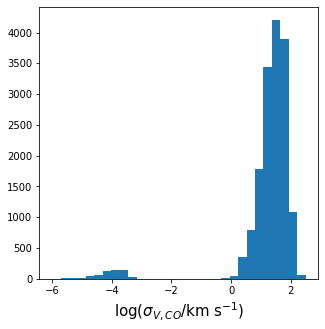

In [232]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(np.log10(Database_SF['CO_vdisp']),bins=np.linspace(-6,2.5,31))
ax.set_xlabel('log($\sigma_{V,CO}$/km s$^{-1}$)',fontsize=15)
print(ax.get_facecolor())
#fig.set_facecolor((0.,0.,0.,0.))
print(fig.get_facecolor())
plt.show()

(1.0, 1.0, 1.0, 1.0)
(1.0, 1.0, 1.0, 1.0)


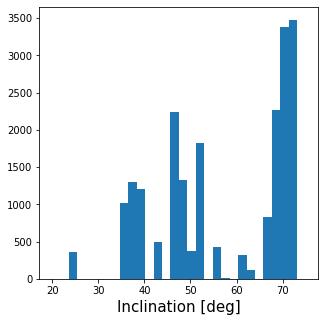

In [275]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(Database_SF['Inclination'],bins=np.linspace(20,75,31))
ax.set_xlabel('Inclination [deg]',fontsize=15)
print(ax.get_facecolor())
#fig.set_facecolor((0.,0.,0.,0.))
print(fig.get_facecolor())
plt.show()


Initializing source UGC01368
Luminsoty distance at z = 0.02652: 116.39 Mpc
SF nonA
4.000000000000577
0.8333333333333932


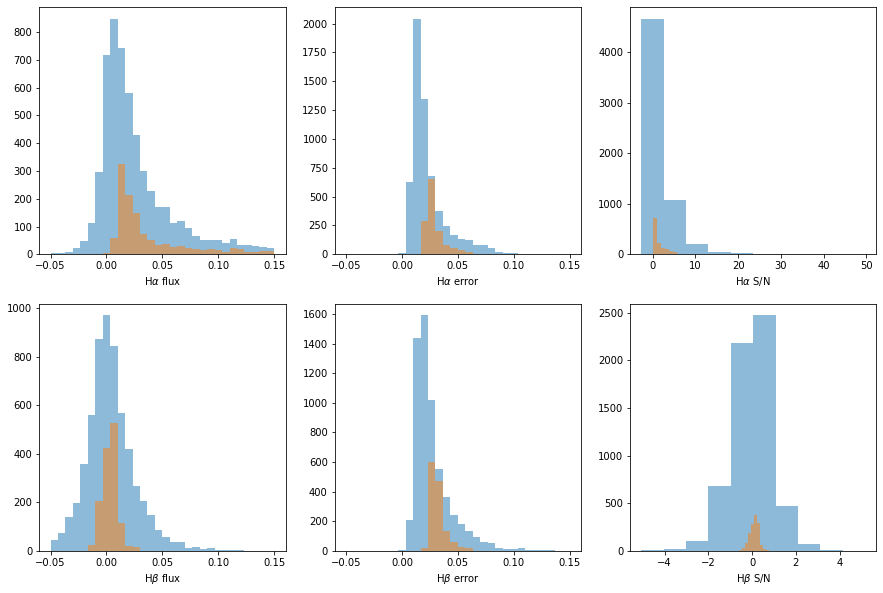

True
False
False


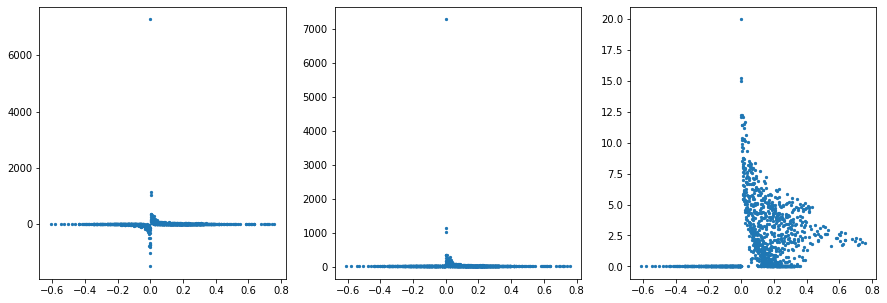

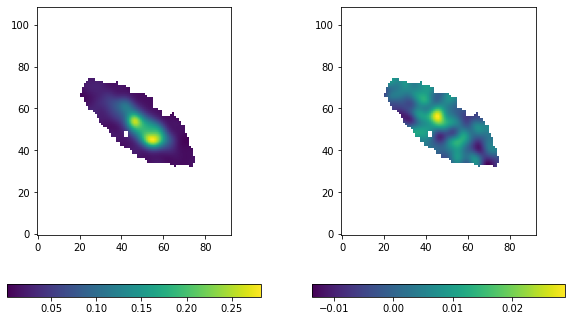

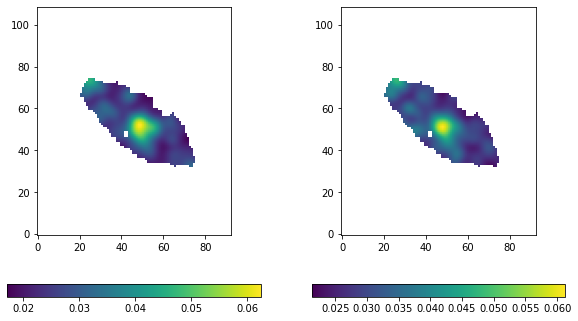

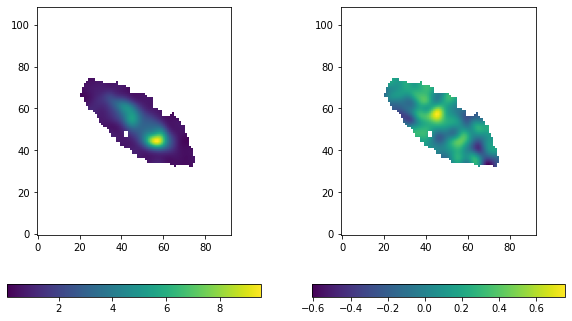

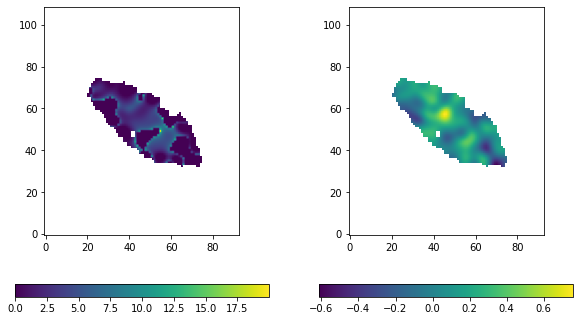

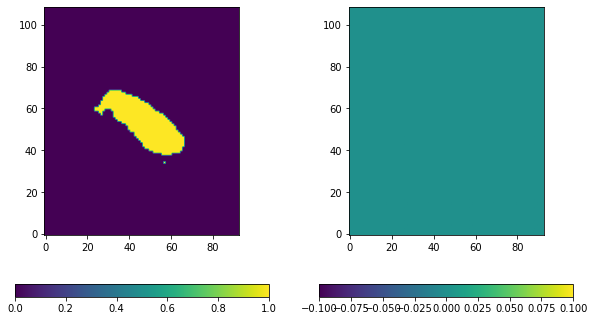

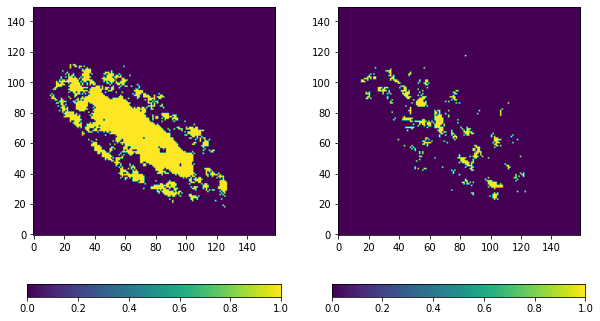

/tmp/ipykernel_870345/2200876307.py:162: RuntimeWarning: Mean of empty slice
  A_Ha_mean_rep = np.nanmean(A_Ha_rep[(A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)])


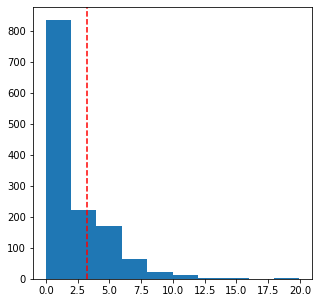

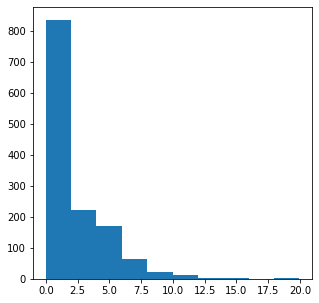

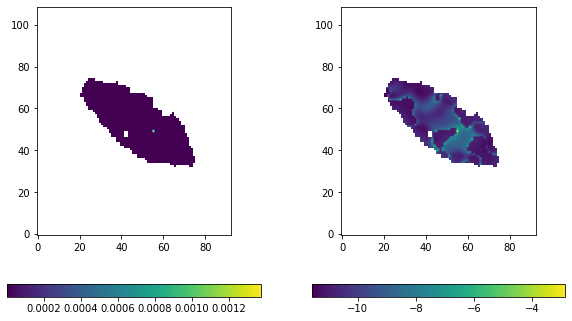

In [258]:
for source in ['UGC01368']:
    print('\nInitializing source',source)
    z = califa_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']
    Re = califa_table.loc[source,'Re_kpc'] # Effective radius in kpc
    hs = Re/(1.68*7.3) # disc scale height in kpc
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    print(f'Luminsoty distance at z = {z:.4}: {D_lum:.5}')
    #print(f'Angular diameter distance at z = {z:.4}: {D_ang:.5}')
    QS = aca_table.loc[source,'Final_QS']
    NA = aca_table.loc[source,'Final_NA']
    print(QS,NA)
    
    #reduced_cube = SpectralCube.read(acaoutpath+source+'_reduced.fits')
    #mom0 = reduced_cube.moment(order=0)
    #dec, ra = mom0.world[:]
    #ra = ra.value
    #dec = dec.value
    #rgrid, tgrid = deproject(ra, dec, [PA,inc,aca_table.loc[source,'RA'],aca_table.loc[source,'DEC']])
    #rgrid = np.deg2rad(rgrid)*D_ang.to(u.kpc)
    
    CO_int, aca_hdr = get_data(acaoutpath+source+'_integrated.fits',header=True)
    CO_vdisp = get_data(acaoutpath+source+'map_2nd.fits')
    pix_scale_aca = aca_hdr['CDELT2']*3600 # spaxel size in arcsec
    pix_area_aca = ((np.deg2rad(aca_hdr['CDELT2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
    #print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')
    
    M_star, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    region, califa_hdr3D = get_data(califaoutpath+source+'_region.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    #print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
    #print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}\n')
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    califa_hdr3D['NAXIS1'] = 0
    califa_hdr3D['NAXIS2'] = 0
    #print(califa_hdr)
    #print(WCS(califa_hdr3D))
    #print(WCS(califa_hdr))
    # convolving CALIFA mpas to ACA resolution
    fwhm_califa = 2.5
    fwhm_aca = 6.
    ppbeam_califa = (fwhm_califa/pix_scale_califa/2)**2 / np.log(2)*np.pi
    ppbeam_aca = (fwhm_aca/pix_scale_aca/2)**2 / np.log(2)*np.pi
    beam_califa = radio_beam.Beam(major=fwhm_califa*u.arcsec, minor=fwhm_califa*u.arcsec, pa=0*u.deg)
    beam_aca = radio_beam.Beam(major=fwhm_aca*u.arcsec, minor=fwhm_aca*u.arcsec, pa=0*u.deg)
    area_factor = pix_area_aca.value/pix_area_califa.value
    scale_factor = np.sqrt(ppbeam_califa/ppbeam_aca)
    
    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb,eF_Ha**2,eF_Hb**2]),wcs=WCS(califa_hdr3D))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)
    frames_cube_convolved = frames_cube.convolve_to(beam_aca)
    frames_cube_convolved = np.array([frame for frame in frames_cube_convolved])
    #frames_cube_convolved[0:5] *= area_factor
    frames_cube_convolved[-1] = np.sqrt(frames_cube_convolved[-1])#*scale_factor
    frames_cube_convolved[-2] = np.sqrt(frames_cube_convolved[-2])#*scale_factor
    
    print(area_factor)
    print(np.sqrt(ppbeam_califa/ppbeam_aca))
    reprojected_list = np.array([reproject_exact((frame,WCS(califa_hdr)),aca_hdr,return_footprint=False) for frame in frames_cube_convolved])
    Ha_mask_rep = reproject_exact((Ha_mask&1,WCS(califa_hdr)),aca_hdr,return_footprint=False)
    
    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep,eF_Ha_rep,eF_Hb_rep] = reprojected_list
    
    S_star_rep = M_star_rep*cos/pix_area_aca.to(u.kpc**2).value # stellar mass surface density in M_sun pc^-2
        
    Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)
    
    fig, axs = plt.subplots(2,3,figsize=(15,10))
    axs[0,0].hist(F_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].hist(F_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,0].set_xlabel(r'H$\alpha$ flux')
    axs[0,1].hist(eF_Ha.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].hist(eF_Ha_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[0,1].set_xlabel(r'H$\alpha$ error')
    axs[0,2].hist(F_Ha.flatten()/eF_Ha.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].hist(F_Ha_rep.flatten()/eF_Ha_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[0,2].set_xlabel(r'H$\alpha$ S/N')
    axs[1,0].hist(F_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].hist(F_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,0].set_xlabel(r'H$\beta$ flux')
    axs[1,1].hist(eF_Hb.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].hist(eF_Hb_rep.flatten(),alpha=0.5,bins=np.linspace(-0.05,0.15,31))
    axs[1,1].set_xlabel(r'H$\beta$ error')
    axs[1,2].hist(F_Hb.flatten()/eF_Hb.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].hist(F_Hb_rep.flatten()/eF_Hb_rep.flatten(),alpha=0.5)#,bins=np.linspace(-0.05,0.15,31))
    axs[1,2].set_xlabel(r'H$\beta$ S/N')
    
    #ax[,].axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax[,].axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    # from Villanueva et al. 2023
    A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
    
    print((F_Ha_rep>eF_Ha_rep).any())
    print((F_Hb_rep>eF_Hb_rep).any())
    print(((A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)).any())
    
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].scatter(F_Hb_rep/eF_Hb_rep,F_Ha_rep/F_Hb_rep,s=5)
    axs[1].scatter(F_Hb_rep/eF_Hb_rep,Ha_to_Hb_rep,s=5)
    axs[2].scatter(F_Hb_rep/eF_Hb_rep,A_Ha_rep,s=5)
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(A_Ha_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha_rep/eF_Ha_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb_rep/eF_Hb_rep>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(F_Ha/eF_Ha>1,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(F_Hb/eF_Hb>1,origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()
    
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
    A_Ha_mean_rep = np.nanmean(A_Ha_rep[(A_Ha_rep>=0)&(F_Hb_rep>eF_Hb_rep)])
    A_Ha_median_rep = np.nanmedian(A_Ha_rep[A_Ha_rep>0])
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    #A_Ha_rep = np.where(~(F_Hb_rep>eF_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)
    
    A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_median_rep,A_Ha_rep)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(A_Ha_rep.flatten())
    #ax.axvline(A_Ha_mean_rep,c='k',ls='-')
    #ax.axvline(A_Ha_median_rep,c='r',ls='--')
    plt.show()
    
    SFR_rep = 1.61*7.9*(10**-(42+16))*F_Ha_rep*np.power(10,A_Ha_rep/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    S_SFR_rep = SFR_rep*cos/pix_area_aca.value
    
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    im = axs[0].imshow(S_SFR_rep/S_star_rep,origin='lower')
    fig.colorbar(im,ax=axs[0],orientation='horizontal')
    im = axs[1].imshow(np.log10(S_SFR_rep/S_star_rep),origin='lower')
    fig.colorbar(im,ax=axs[1],orientation='horizontal')
    plt.show()


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.scatter(np.log10(Database_SF['P_h']),frame,s=5)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    ax.hexbin(np.log10(Database_SF['P_h']),frame,mincnt=1)#,label='ACA resolution')
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    #ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,sharex='col',sharey='row')
for ax,frame,title,label in zip(axs.ravel(),[np.log10(Database_SF['f_CO']),np.log10(Database_SF['S_SFR']),np.log10(Database_SF['sSFR']),np.log10(Database_SF['SFE'])],
                          [r'$f_\mathrm{CO}$',r'$\Sigma_\mathrm{SFR}$','sSFR','SFE'],[r'log($f_\mathrm{CO}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',r'log(sSFR/yr$^{-1}$)',r'log(SFE/yr$^{-1}$)']):
    #mask = np.floor(Database['Ha_mask'])==1
    for QS in ['SF','MX','nR','cQ','QnR','fR']:
        ax.scatter(np.log10(Database_SF.loc[Database_SF['Final_QS']==QS,'P_h']),frame[Database_SF['Final_QS']==QS],s=5,label=QS)
    #ax.scatter(np.log10(Database.loc[~mask,'P_h']),frame[~mask],s=5,label='ACA resolution')
    #ax.scatter(np.log10(Ph_hex),frame[1],s=5,label='PyStructure')
    ax.set_ylabel(label,size=15)
    ax.grid(True)
    ax.set_xlabel(r'log(P$_\mathrm{h}$/$k_\mathrm{B}$K cm$^{-3}$)',size=15)
    ax.legend(loc='best')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['R_21'],bins=np.linspace(0,1.5,30),alpha=0.5,label=r'R$_\mathrm{21}$ distribution')
median = np.nanmedian(Database['R_21'])
ax.axvline(np.nanmedian(Database['R_21']),ls='--',c='b',label=f'median: {median:.3}')
ax.set_xlabel(r'R$_\mathrm{21}$',size=12)
ax.set_title(r'R$_\mathrm{21}$ distribution',size=15)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
#for ax,O3N2,N2,title in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_O3N2_rep],[alphaCO_N2,alphaCO_N2_rep],['Original maps','Reprojected maps']):
ax.hist(Database['alphaCO_O3N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from O3N2')
ax.hist(Database['alphaCO_N2'],bins=np.linspace(0.,12,30),alpha=0.5,label='from N2')
median_O3N2 = np.nanmedian(Database['alphaCO_O3N2'])
median_N2 = np.nanmedian(Database['alphaCO_N2'])
ax.axvline(median_O3N2,ls='--',c='b',label=f'median: {median_O3N2:.3}')
ax.axvline(median_N2,ls='--',c='r',label=f'median: {median_N2:.3}')
ax.axvline(alphaCO_MW,ls='--',c='g',label=f'Milky Way: {alphaCO_MW:.3}')
ax.set_xlabel(r'$\alpha_\mathrm{CO}$ [M$_\odot$K$^{-1}$km$^{-1}$s pc$^{-2}$]',size=12)
ax.legend(loc='best')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))#,sharey='row')
#for ax,ZO3N2,ZN2 in zip(axs.ravel(),[Z_O3N2.flatten(),Z_O3N2_rep.flatten()],[Z_N2.flatten(),Z_N2_rep.flatten()]):
axs[0].hexbin(np.log10(Database['Z_O3N2']),np.log10(Database['Z_N2']),bins='log',mincnt=1)
axs[0].plot([-1.,1.],[-1.,1.],c='k',ls='--')
axs[0].set_xlabel(r'log(Z$_\mathrm{O3N2}$/Z$_\odot$)',size=15)
axs[0].set_ylabel(r'log(Z$_\mathrm{N2}$/Z$_\odot$)',size=15)
axs[1].hexbin(Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_O3N2'],Database.loc[(Database['alphaCO_O3N2']<=12)&(Database['alphaCO_N2']<=12),'alphaCO_N2'],bins='log',mincnt=1)
axs[1].plot([1.,12.],[1.,12.],c='k',ls='--')
axs[1].set_xlabel(r'$\alpha_\mathrm{CO (O3N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
axs[1].set_ylabel(r'$\alpha_\mathrm{CO (N2)}$ [M$_\odot$/(K km s$^{-1}$ pc$^2$)]',size=15)
fig.tight_layout()
plt.show()

In [29]:
    beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
    beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

    frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb]),wcs=WCS(califa_hdr))
    frames_cube = frames_cube.with_mask(region)
    frames_cube = frames_cube.with_beam(beam_califa)

    frames_cube_convolved = frames_cube.convolve_to(beam_CO)

    area_factor = pix_area_aca.value/pix_area_califa.value
    reprojected_list = []
    for frame in frames_cube_convolved:
        reprojected, footprint = reproject_exact((frame,WCS(califa_hdr)),target_header)
        reprojected_list.append(reprojected*area_factor)
    reprojected_list = np.array(reprojected_list)

    [M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep] = reprojected_list

CGCG429-012
Luminsoty distance at z = 0.01746: 76.125 Mpc
Angular diameter distance at z = 0.01746: 73.534 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.285961 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0317734 kpc2

IC1079
Luminsoty distance at z = 0.02907: 127.81 Mpc
Angular diameter distance at z = 0.02907: 120.69 Mpc
Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.770337 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.085593 kpc2

IC1528
Luminsoty distance at z = 0.01252: 54.363 Mpc
Angular diameter distance at z = 0.01252: 53.027 Mpc
Angular size of ACA spaxel: 1.0 arcsec
Surface area per ACA spaxel: 0.0660911 kpc2
Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0165228 kpc2



In [ ]:
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(califa_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star,F_OIII,F_Ha,F_Hb],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()
    
    fig, axs = plt.subplots(2,2,figsize=(10,12),subplot_kw={'projection':WCS(aca_hdr)})
    for ax,image,label in zip(axs.ravel(),[M_star_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep],['M_star','F_OIII','F_Ha','F_Hb']):
        im = ax.imshow(image,origin='lower')#,vmin=vmin,vmax=vmax)
        fig.colorbar(im, ax=ax,orientation='horizontal')
        ax.set_title(label+' map',fontsize=15)
        ax.coords['ra'].set_axislabel('RA')
        ax.coords['dec'].set_axislabel('DEC')
    plt.show()

>f8


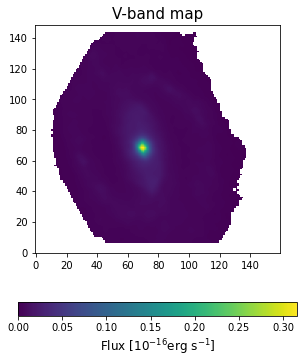

In [78]:
hdu_list = fits.open(califainpath+'UGC12250'+'.Pipe3D.cube.fits.gz')
gaia = hdu_list[7].data
region = hdu_list[8].data
print(gaia.dtype)
    #region = region&(~np.ceil(gaia))
    
v_band = np.where(region,hdu_list[1].data[0],np.nan)
    
fig, ax = plt.subplots(figsize=(5,6))
im = ax.imshow(v_band,origin='lower')
cb = fig.colorbar(im,ax=ax,orientation='horizontal')
cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
ax.set_title('V-band map',size=15)
plt.show()
plt.close()
    
hdu_list.close()

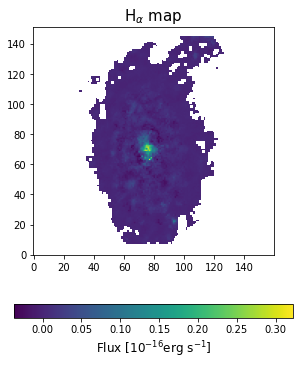

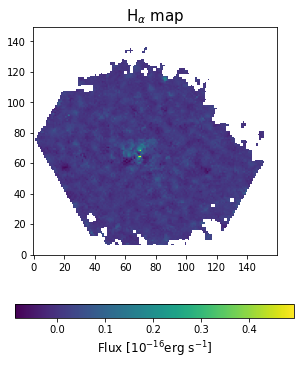

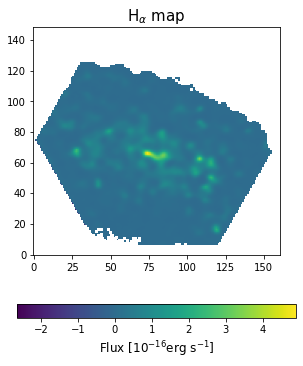

In [24]:
for source in sources[:3]:
    hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    gaia = hdu_list[7].data
    region = hdu_list[8].data
    #print(gaia.dtype)
    region = region&np.where(gaia!=0,0,1)
    
    #v_band = np.where(region,hdu_list[1].data[0],np.nan)
    Ha = np.where(region,hdu_list[5].data[45],np.nan)
    
    fig, ax = plt.subplots(figsize=(5,6))
    im = ax.imshow(Ha,origin='lower')
    cb = fig.colorbar(im,ax=ax,orientation='horizontal')
    cb.set_label(r'Flux [10$^{-16}$erg s$^{-1}$]',size=12)
    ax.set_title(r'H$_\alpha$ map',size=15)
    plt.show()
    #plt.savefig(califaoutpath+'/califa_images/'+source+'vband.png')
    plt.close()
    
    hdu_list.close()